In [11]:
import pandas as pd
import numpy as np

In [12]:
def integ(eps, t):
    if eps == 0:
        return t
    else:
        return (1/eps)*(1-np.exp(-eps*t))

def calc_prob(alpha, beta, gamma, t, mu):
    res = 0
    res += (1/64)*integ(1,t)
    res += (1/16)*gamma*np.exp(-t*mu)*integ(1-mu,t)
    res += (1/16)*(alpha+beta)*integ(1+mu,t)
    res += (1/4)*(alpha+beta)*gamma*np.exp(-t*mu)*integ(1,t)
    res += (1/4)*alpha*beta*integ(1+2*mu,t)
    res += alpha*beta*gamma*np.exp(-t*mu)*integ(1+mu,t)
    return res

def wrapper(a, b, c, d, t, mu):
    alpha = 3/4 if a==d else -1/4
    beta  = 3/4 if b==d else -1/4
    gamma = 3/4 if c==d else -1/4
    return (1/(1-np.exp(-t)))*calc_prob(alpha, beta, gamma, t, mu)

def calc_df(t, mu):
    arr = []
    for a in ['A', 'C', 'T', 'G']:
        for b in ['A', 'C', 'T', 'G']:
            for c in ['A', 'C', 'T', 'G']:
                for d in ['A', 'C', 'T', 'G']:
                    arr.append([a, b, c, d, wrapper(a, b, c, d, t, mu)])
    return pd.DataFrame(arr, columns = ['a', 'b', 'c', 'd', 'prob'])

In [13]:
wrapper('A', 'C', 'A', 'A', 0.007, 0.2)

0.0001745310058324659

$P(b,c,d|a,\mu,t)=$

In [14]:
t = 0.5
theta = 2
mu = (4/3)*theta
df = calc_df(t, mu)
df

,a,b,c,d,prob
0,A,A,A,A,0.287676
1,A,A,A,C,0.001102
2,A,A,A,T,0.001102
3,A,A,A,G,0.001102
4,A,A,C,A,0.069801
...,...,...,...,...,...
251,G,G,T,G,0.069801
252,G,G,G,A,0.001102
253,G,G,G,C,0.001102
254,G,G,G,T,0.001102


In [15]:
df.groupby(['a']).sum()

,prob
a,
A,1.0
C,1.0
G,1.0
T,1.0


$P(b,c|a,\mu,t)=$

In [16]:
df.groupby(['a', 'b', 'c']).sum()

prob
a b c          
A A A  0.290981
    C  0.082434
    G  0.082434
    T  0.082434
  C A  0.052239
...         ...
T G T  0.052239
  T A  0.082434
    C  0.082434
    G  0.082434
    T  0.290981

[64 rows x 1 columns]

In [17]:
def rate_mat(mu, t):
    return (1/4)+np.exp(-t*mu)*(1/4)*(np.full((4, 4), -1)+np.diag([4, 4, 4, 4]))
def wrapper_2(mu, t):
    bases = {0:'A', 1:'C', 2:'T', 3:'G'}
    arr1 = rate_mat(mu, t)
    df1 = pd.DataFrame(arr1).stack().reset_index()
    df1['level_0'] = [bases[i] for i in df1['level_0']]
    df1['level_1'] = [bases[i] for i in df1['level_1']]
    df1.columns = ['A','a','prob']
    return df1

$P(a|A)=$

In [18]:
mu_A = 0.5
t_AB = 3
wrapper_2(mu_A, t_AB)

,A,a,prob
0,A,A,0.417348
1,A,C,0.194217
2,A,T,0.194217
3,A,G,0.194217
4,C,A,0.194217
5,C,C,0.417348
6,C,T,0.194217
7,C,G,0.194217
8,T,A,0.194217
9,T,C,0.194217


$P(a,A)=P(A)P(a|A)=(1/4)\cdot P(a|A)$

$P(b,B)=P(B)P(b|B)=(1/4)\cdot P(b|B)$

$P(c|A,B)=\sum_{d}P(c,d|A,B)=\sum_{d}\sum_{a}P(c,d|a,A,B)=\sum_{d}\sum_{a}\sum_{b}P(c,d|a,A,bB)$

$P(c|A,B)=\sum_{a}\sum_{b}P(c|a,A,b,B)=\sum_{a}\sum_{b}\frac{P(c,A,B|a,b)}{P(A,B)}$

## Emission probs

In [31]:
t1 = 0.1 # a to A
t2 = 0.5 # ab to c
t3 = 0.3 # c to a'
t4 = 0.2 # a'b' to c'
t5 = t1+t2+t3+t4+0.4 # c' to D
t6 = t1+t2+t3 # b' to C
theta = 2
mu = (4/3)*theta

$P(b,c|a)=$

In [20]:
# b,c | a
df2 = calc_df(t2, mu).groupby(['a', 'b', 'c']).sum().reset_index()
df2_ = df2.groupby(['a', 'b']).apply(lambda x: dict(zip(x.c, x.prob))).reset_index()
df2_.columns = ['a', 'b', 'val']
df2_ = df2_.groupby('a').apply(lambda x: dict(zip(x.b, x.val))).to_dict()
# df2_[a][b][c]

# b',c' | a'
df4 = calc_df(t4, mu).groupby(['a', 'b', 'c']).sum().reset_index()
df4_ = df4.groupby(['a', 'b']).apply(lambda x: dict(zip(x.c, x.prob))).reset_index()
df4_.columns = ['a', 'b', 'val']
df4_ = df4_.groupby('a').apply(lambda x: dict(zip(x.b, x.val))).to_dict()
# df4_[a'][b'][c']

$P(a|A)=$

In [21]:
# a | A
df1 = wrapper_2(mu, t1)
df1_ = df1.groupby(['A']).apply(lambda x: dict(zip(x.a, x.prob))).to_dict()
# df1_[A][a]

# B | b
df3 = wrapper_2(mu, t3)
df3_ = df3.groupby(['A']).apply(lambda x: dict(zip(x.a, x.prob))).to_dict()
# df3_[b][B]

# D | c'
df5 = wrapper_2(mu, t5)
df5_ = df5.groupby(['A']).apply(lambda x: dict(zip(x.a, x.prob))).to_dict()
# df5_[c'][D]

# C | b'
df6 = wrapper_2(mu, t6)
df6_ = df6.groupby(['A']).apply(lambda x: dict(zip(x.a, x.prob))).to_dict()
# df5_[b'][C]

$P(A,B,C,D)=\pi(A)P(B,C,D|A)=\pi(A)\sum_{a,b,c}\sum_{a',b',c'}P(a,b,c,d,a',b',c',d',B,C,D|A)=\\ \pi(A)\sum_{a,b,c}\sum_{a',b',c'}P(a|A)P(b,c|a)P(B|b)P(a'|c)P(b',c'|a')P(C|b')P(D|c')$

In [32]:
emissions = {}
for A in ['A', 'C', 'T', 'G']:
    for B in ['A', 'C', 'T', 'G']:
        for C in ['A', 'C', 'T', 'G']:
            for D in ['A', 'C', 'T', 'G']:
                acc = 0
                for a in ['A', 'C', 'T', 'G']:
                    for b in ['A', 'C', 'T', 'G']:
                        for c in ['A', 'C', 'T', 'G']:
                            for a_ in ['A', 'C', 'T', 'G']:
                                for b_ in ['A', 'C', 'T', 'G']:
                                    for c_ in ['A', 'C', 'T', 'G']:
                                        res = 1
                                        res = res*df1_[A][a]
                                        res = res*df1_[b][B]
                                        res = res*df2_[a][b][c]
                                        res = res*df3_[c][a_]
                                        res = res*df4_[a_][b_][c_]
                                        res = res*df6_[b_][C]
                                        res = res*df5_[c_][D]
                                        acc += res
                emissions[A+B+C+D] = acc/4
                                        


In [33]:
sum(list(emissions.values()))

1.0

# Two coalescents at the same interval

In [101]:
import numpy as np
from scipy.integrate import dblquad
import pandas as pd

In [121]:
t = 0.2
# t = np.inf
mu = 0.1
prmv = [0, 0, 0, 0, 0]
k = 1+0.5*np.exp(-3*t)-1.5*np.exp(-t)

In [116]:
def g(u,v,prm=prmv,mu=mu,t=t):
    tmp = 1
    tm = [-mu*u,-mu*u,-mu*v,-mu*(v+u),-mu*(t-v-u)]
    for i in range(5):
        tmp = tmp*(1/4+prm[i]*np.exp(tm[i]))
    tmp = tmp*3*np.exp(-3*u)*np.exp(-(v-u))
    return tmp
def g_wrapper(u,v):
    return g(u,v,prm=prmv,mu=mu,t=t)

In [122]:
# t = np.inf
arr = []
for aa in ['A', 'T', 'G', 'C']:
    for bb in ['A', 'T', 'G', 'C']:
        for cc in ['A', 'T', 'G', 'C']:
            for dd in ['A', 'T', 'G', 'C']:
                cumsum = 0
                for ee in ['A', 'T', 'G', 'C']:
                    for ff in ['A', 'T', 'G', 'C']:
                        prmv[0] = 3/4 if aa==ee else -1/4
                        prmv[1] = 3/4 if ee==bb else -1/4
                        prmv[2] = 3/4 if ee==ff else -1/4
                        prmv[3] = 3/4 if ff==cc else -1/4
                        prmv[4] = 3/4 if ff==dd else -1/4
                        res, err = dblquad(lambda x, y: g(y,x,prm=prmv,mu=mu,t=t), 0, t, lambda x: x, lambda x: t)
                        cumsum += res
                arr.append([aa, bb, cc, dd, cumsum/k])
df = pd.DataFrame(arr, columns = ['a', 'b', 'c', 'd', 'prob'])

$P(b,c,d|a)=$

In [123]:
df

,a,b,c,d,prob
0,A,A,A,A,0.195468
1,A,A,A,T,0.195468
2,A,A,A,G,0.195468
3,A,A,A,C,0.195468
4,A,A,T,A,0.014271
...,...,...,...,...,...
251,C,C,G,C,0.014271
252,C,C,C,A,0.195468
253,C,C,C,T,0.195468
254,C,C,C,G,0.195468


In [126]:
df.groupby(['a']).sum()

,prob
a,
A,1.0
C,1.0
G,1.0
T,1.0


In [40]:
df_ = df.groupby(['a', 'b', 'c']).apply(lambda x: dict(zip(x.d, x.prob))).reset_index()
df_.columns = ['a', 'b', 'c', 'val']
df_ = df_.groupby(['a', 'b']).apply(lambda x: dict(zip(x.c, x.val))).reset_index()
df_.columns = ['a', 'b', 'val']
df_ = df_.groupby('a').apply(lambda x: dict(zip(x.b, x.val))).to_dict()

$P(a|A)=$

In [41]:
t1 = 0.5 # a to A
# a | A  //  B | b  //  C | c
df1 = wrapper_2(mu, t1)
df1_ = df1.groupby(['A']).apply(lambda x: dict(zip(x.a, x.prob))).to_dict()
# df1_[A][a]  //  df1_[b][B]  //  df1_[c][C]

t2 = t1+0.4 # d to D
# D | d
df2 = wrapper_2(mu, t2)
df2_ = df2.groupby(['A']).apply(lambda x: dict(zip(x.a, x.prob))).to_dict()
# df2_[d][D]

In [43]:
emissions = {}
for A in ['A', 'C', 'T', 'G']:
    for B in ['A', 'C', 'T', 'G']:
        for C in ['A', 'C', 'T', 'G']:
            for D in ['A', 'C', 'T', 'G']:
                acc = 0
                for a in ['A', 'C', 'T', 'G']:
                    for b in ['A', 'C', 'T', 'G']:
                        for c in ['A', 'C', 'T', 'G']:
                            for d in ['A', 'C', 'T', 'G']:
                                res = 1
                                res = res*df1_[A][a]
                                res = res*df1_[b][B]
                                res = res*df1_[c][C]
                                res = res*df_[a][b][c][d]
                                res = res*df2_[d][D]
                                acc += res
                emissions[A+B+C+D] = acc/4

In [45]:
sum(list(emissions.values()))

1.0000000000000004

# Unified framework

In [130]:
def calc_emissions_single(t_vec, theta_vec):
    
    t1 = t_vec[0] # a to A
    t2 = t_vec[1] # ab to c
    t3 = t_vec[2] # c to a'
    t4 = t_vec[3] # a'b' to c'
    t5 = t1+t2+t3+t4+t_vec[4] # c' to D
    t6 = t1+t2+t3 # b' to C
    mu_vec = [(4/3)*theta for theta in theta_vec]
    mu1 = mu_vec[0]
    mu2 = mu_vec[1]
    mu3 = mu_vec[2]
    mu4 = mu_vec[3]
    mu5 = mu_vec[4]
    mu6 = mu_vec[5]
    
    # b,c | a
    df2 = calc_df(t2, mu2).groupby(['a', 'b', 'c']).sum().reset_index()
    df2_ = df2.groupby(['a', 'b']).apply(lambda x: dict(zip(x.c, x.prob))).reset_index()
    df2_.columns = ['a', 'b', 'val']
    df2_ = df2_.groupby('a').apply(lambda x: dict(zip(x.b, x.val))).to_dict()
    # df2_[a][b][c]

    # b',c' | a'
    df4 = calc_df(t4, mu4).groupby(['a', 'b', 'c']).sum().reset_index()
    df4_ = df4.groupby(['a', 'b']).apply(lambda x: dict(zip(x.c, x.prob))).reset_index()
    df4_.columns = ['a', 'b', 'val']
    df4_ = df4_.groupby('a').apply(lambda x: dict(zip(x.b, x.val))).to_dict()
    # df4_[a'][b'][c']
    
    # a | A
    df1 = wrapper_2(mu1, t1)
    df1_ = df1.groupby(['A']).apply(lambda x: dict(zip(x.a, x.prob))).to_dict()
    # df1_[A][a]

    # B | b
    df3 = wrapper_2(mu3, t3)
    df3_ = df3.groupby(['A']).apply(lambda x: dict(zip(x.a, x.prob))).to_dict()
    # df3_[b][B]

    # D | c'
    df5 = wrapper_2(mu5, t5)
    df5_ = df5.groupby(['A']).apply(lambda x: dict(zip(x.a, x.prob))).to_dict()
    # df5_[c'][D]

    # C | b'
    df6 = wrapper_2(mu6, t6)
    df6_ = df6.groupby(['A']).apply(lambda x: dict(zip(x.a, x.prob))).to_dict()
    # df5_[b'][C]
    
    emissions = {}
    for A in ['A', 'C', 'T', 'G']:
        for B in ['A', 'C', 'T', 'G']:
            for C in ['A', 'C', 'T', 'G']:
                for D in ['A', 'C', 'T', 'G']:
                    acc = 0
                    for a in ['A', 'C', 'T', 'G']:
                        for b in ['A', 'C', 'T', 'G']:
                            for c in ['A', 'C', 'T', 'G']:
                                for a_ in ['A', 'C', 'T', 'G']:
                                    for b_ in ['A', 'C', 'T', 'G']:
                                        for c_ in ['A', 'C', 'T', 'G']:
                                            res = 1
                                            res = res*df1_[A][a]
                                            res = res*df1_[b][B]
                                            res = res*df2_[a][b][c]
                                            res = res*df3_[c][a_]
                                            res = res*df4_[a_][b_][c_]
                                            res = res*df6_[b_][C]
                                            res = res*df5_[c_][D]
                                            acc += res
                    emissions[A+B+C+D] = acc/4
    
    return emissions

In [131]:
emissions_test = calc_emissions_single(t_vec = [0.01, 0.2, 0, 0.5, 0.2], theta_vec = [1, 1.3, 1.4, 1.4, 1.2, 0.6])

In [132]:
em = pd.DataFrame({'col1':emissions_test.keys(), 'col2':emissions_test.values()})

In [93]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


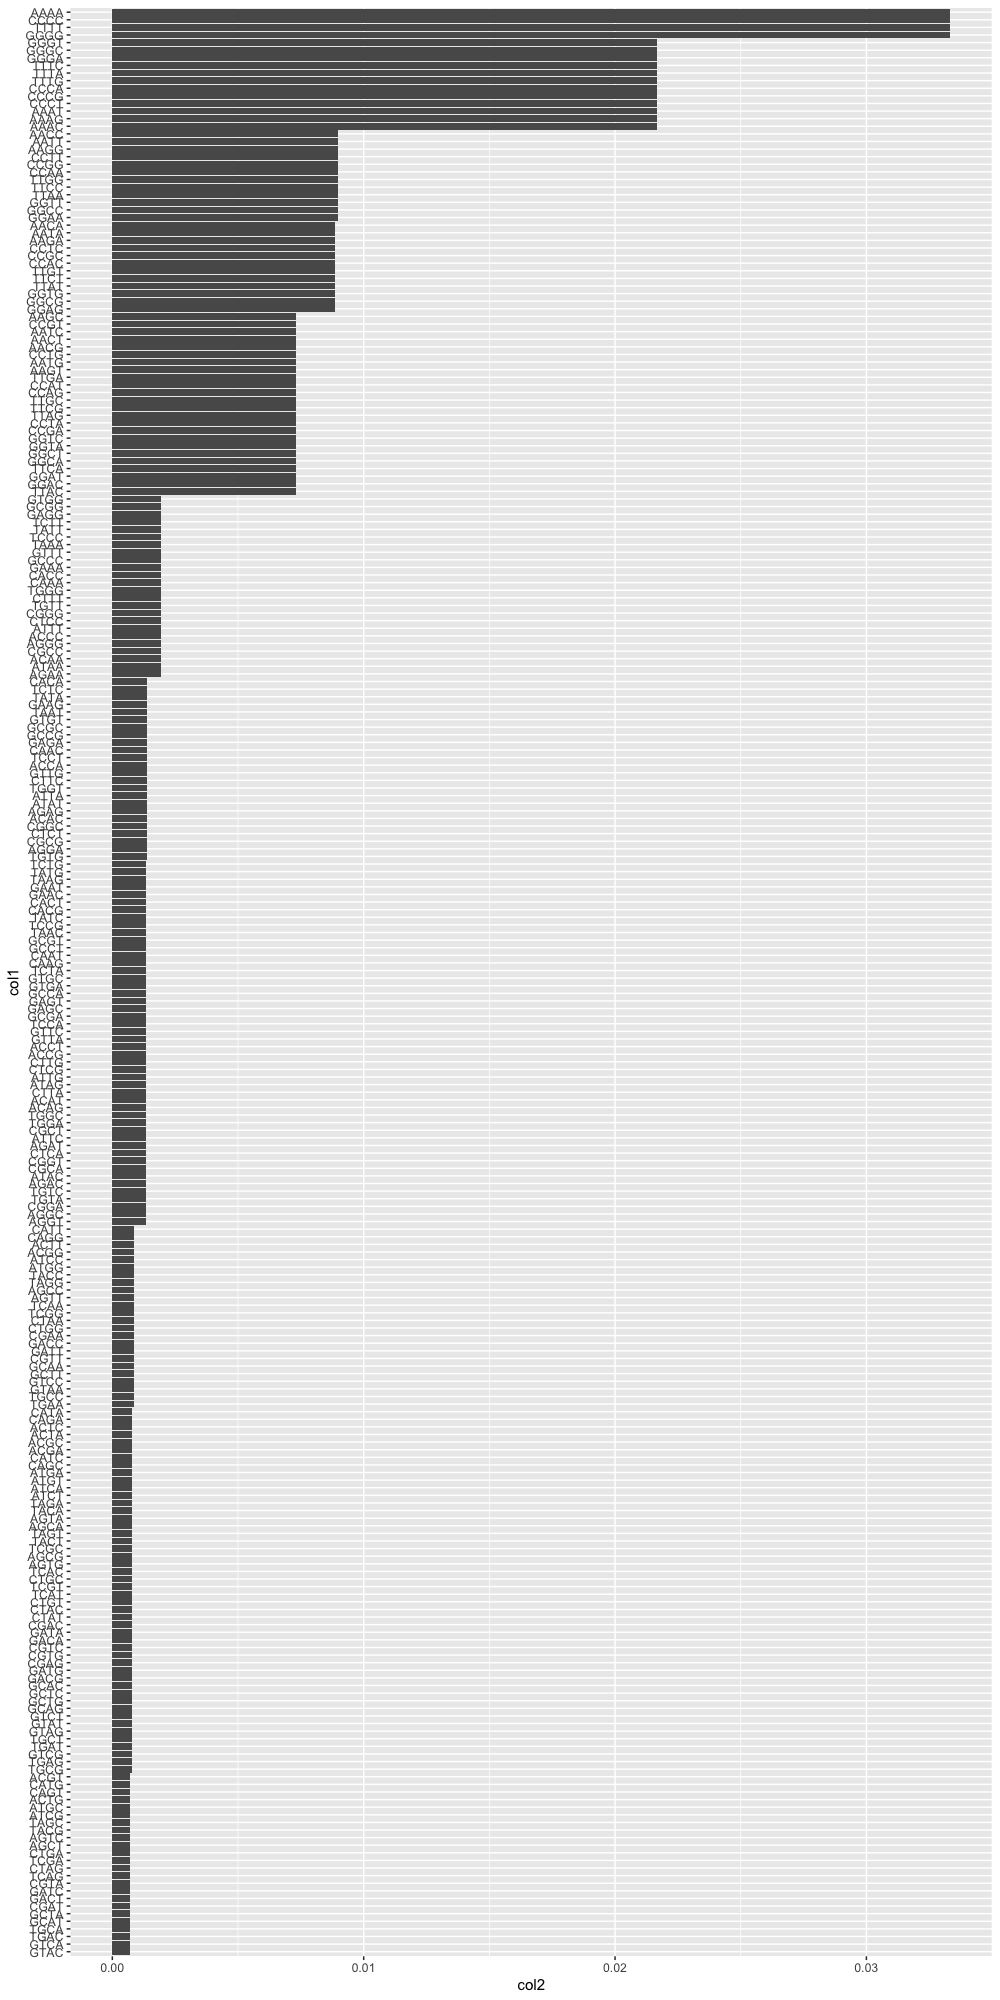

In [94]:
%%R -i em -w 1000 -h 2000 -r 100

library(tidyverse)

em %>%
    mutate(col1 = reorder(col1, col2)) %>%
    ggplot() +
    geom_col(aes(col1, col2)) +
    coord_flip()

In [49]:
def integ(x, t):
    if x == 0:
        return t
    else:
        return (1/x)*(1-np.exp(-x*t))

In [50]:
def gfun(start, tupper, ininteg, t):
    return start*np.exp(tupper)*integ(ininteg, t)

In [70]:
def iterator(k_list, a_list, b_list, c_list, alpha, beta, t, mu):
    res = 0
    for i in range(8):
        k = k_list[i]
        a = a_list[i]
        b = b_list[i]
        c = c_list[i]
        start_list = [
             (alpha*beta*k)/(c),  (alpha*k)/(4*c),  (beta*k)/(4*c),  (k)/(16*c),
            -(alpha*beta*k)/(c), -(alpha*k)/(4*c), -(beta*k)/(4*c), -(k)/(16*c)
        ]
        tupper_list = [a,     a,     a,     a, 
                       a-c*t, a-c*t, a-c*t, a-c*t]
        ininteg_list = [
            3+2*mu-b+c, 3+mu-b+c, 3+mu-b+c, 3-b+c,
            3+2*mu-b,   3+mu-b,   3+mu-b,   3-b
        ]
        for j in range(8):
            res += gfun(start_list[j], tupper_list[j], ininteg_list[j], t)
    return res

In [83]:
def wrapper_2(a, b, c, d, e, f, t, mu):
    alpha   = 3/4 if a==e else -1/4
    beta    = 3/4 if e==b else -1/4
    gamma   = 3/4 if e==f else -1/4
    delta   = 3/4 if f==c else -1/4
    epsilon = 3/4 if f==d else -1/4
    constant = 3/(1+0.5*np.exp(-3*t)-1.5*np.exp(-t))
    k_list = [
        1/64, delta/16, gamma/16, (delta*gamma)/4, 
        epsilon/16, (delta*epsilon)/4, (gamma*epsilon)/4, gamma*delta*epsilon
    ]
    a_list = [0, 0, 0, 0, -mu*t, -mu*t, -mu*t, -mu*t]
    b_list = [0, -mu, 0, -mu, mu, 0, mu, 0]
    c_list = [1, mu+1, mu+1, 2*mu+1, 1-mu, 1, 1, 1+mu]
    return constant*iterator(k_list, a_list, b_list, c_list, alpha, beta, t, mu)

In [105]:
wrapper_2('A', 'A', 'A', 'A', 'A', 'C', 0.001, 10)

-2.7990143710363957e-09

In [121]:
t = 4
theta = 10
mu = (4/3)*theta
arr = []
for a in ['A', 'C', 'T', 'G']:
    for b in ['A', 'C', 'T', 'G']:
        for c in ['A', 'C', 'T', 'G']:
            for d in ['A', 'C', 'T', 'G']:
                for e in ['A', 'C', 'T', 'G']:
                    for f in ['A', 'C', 'T', 'G']:
                        arr.append([a, b, c, d, e, f, wrapper_2(a, b, c, d, e, f, t, mu)])
df = pd.DataFrame(arr, columns = ['a', 'b', 'c', 'd', 'e', 'f', 'prob'])
# df

In [122]:
df.groupby(['a']).sum()

,prob
a,
A,0.749023
C,0.749023
G,0.748657
T,0.749146


In [93]:
0.697619+0.014387*3

0.74078